In [1]:
import sys
from os import path
sys.path.insert(1, path.join(sys.path[0], '..'))

In [2]:
from itertools import combinations

In [3]:
import torch
import torch.nn as nn
import numpy as np

In [4]:
from levers import IteratedLeverEnvironment
from levers.partners import FixedPatternPartner
from levers.learner import DQNAgent, HistoryShaper, Transition

In [5]:
# Experiment settings
n_eval_mc = 10
n_train_mc = 3

# Final results table
# Format: eval_id, train_id, test_pattern_id, train_patterns_id
scores = torch.zeros((70, 8, n_train_mc, n_eval_mc))
greedy_scores = torch.zeros((70, 8, n_train_mc, n_eval_mc))

In [6]:
def eval_online_q_learner(train_patterns, test_pattern, train_id):
    # Environment settings
    payoffs = [1., 1.]
    truncated_length = 100
    include_step = False
    include_payoffs = False

    # Construct environment
    env = IteratedLeverEnvironment(
        payoffs, truncated_length+1, FixedPatternPartner(test_pattern),
        include_step, include_payoffs
    )


    # History shaper settings
    hs_hidden_size = 4

    # Construct history shaper
    hist_shaper = HistoryShaper(
        hs_net=nn.LSTM(
            input_size=len(env.dummy_obs()),
            hidden_size=hs_hidden_size,
        )
    )

    # Load history shaper from experiment
    experiment_name = 'online_qlearner_all_length3_manual'
    data_dir = 'data'
    model_name = 'hs-net-pattern={tps}-eval_id={eid:02d}.pt'.format(
        tps=train_patterns,
        eid=train_id
    )
    model_path = path.join(experiment_name, data_dir, model_name)
    hist_shaper.net.load_state_dict(torch.load(model_path))


    # Learner settings
    learner_hidden_size = 4
    capacity = 16
    batch_size = 8
    lr = 0.01
    gamma = 0.99
    len_update_cycle = 10

    # Initialize DQN agent
    learner = DQNAgent(
        q_net=nn.Sequential(
            nn.Linear(hs_hidden_size, learner_hidden_size),
            nn.ReLU(),
            nn.Linear(learner_hidden_size, env.n_actions()),
        ),
        capacity=capacity,
        batch_size=batch_size,
        lr=lr,
        gamma=gamma,
        len_update_cycle=len_update_cycle
    )

    # Load q-net from experiment
    experiment_name = 'online_qlearner_all_length3_manual'
    data_dir = 'data'
    model_name = 'q-net-pattern={tps}-eval_id={eid:02d}.pt'.format(
        tps=train_patterns,
        eid=train_id
    )
    model_path = path.join(experiment_name, data_dir, model_name)
    learner.q_net.load_state_dict(torch.load(model_path))
    learner.reset()

    ret, greedy_ret, greedy_steps = 0, 0, 0
    obs = env.reset()
    obs_rep, hidden = hist_shaper.net(obs.unsqueeze(0))
    for step in range(truncated_length):
        epsilon = 1 * (1 - 4 * step / truncated_length)
        action, is_greedy = learner.act(obs_rep.squeeze(0), epsilon=epsilon)
        next_obs, reward, done = env.step(action)

        ret += reward
        greedy_ret += reward if is_greedy else 0
        greedy_steps += is_greedy

        # Compute history representation
        next_obs_rep, next_hidden = hist_shaper.net(
            next_obs.unsqueeze(0), hidden)

        # Give experience to learner and train
        learner.update_memory(
            Transition(
                obs_rep.squeeze(0).detach(),
                action, 
                next_obs_rep.squeeze(0).detach(), 
                reward, done
            )
        )
        learner.train(done)

        # Update next observation -> observation
        obs = next_obs
        obs_rep = next_obs_rep
        hidden = next_hidden

    score = ret / truncated_length
    greedy_score = greedy_ret / greedy_steps
    return score, greedy_score

In [21]:
patterns = [
    (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
    (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1),
]

for train_patterns_id, train_patterns in enumerate(combinations(patterns, 4)):
    print('-' * 50)
    for test_pattern_id, test_pattern in enumerate(patterns):
        for train_id in range(n_train_mc):
            for eval_id in range(n_eval_mc):
                score, greedy_score = eval_online_q_learner(
                    train_patterns, test_pattern, train_id) 
                scores[train_patterns_id, test_pattern_id, train_id, eval_id] = score
                greedy_scores[train_patterns_id, test_pattern_id, train_id, eval_id] = greedy_score
        in_train_patterns = '*' if test_pattern in train_patterns else ' '
        np.set_printoptions(precision=3)
        print('{tps_id: 2d}/70 | {testp} ({flag}): actual: {actual}, greedy: {greedy}'.format(
            tps_id=train_patterns_id+1,
            testp=test_pattern,
            flag=in_train_patterns,
            actual=scores[train_patterns_id, test_pattern_id,:,:].mean(dim=1).numpy(),
            greedy=greedy_scores[train_patterns_id, test_pattern_id,:,:].mean(dim=1).numpy(),
        ))
    avg_train_score = torch.stack([scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern in train_patterns]).mean().item()
    avg_test_scores = torch.stack([scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern not in train_patterns]).mean().item()
    avg_greedy_train_score = torch.stack([greedy_scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern in train_patterns]).mean().item()
    avg_greedy_test_scores = torch.stack([greedy_scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern not in train_patterns]).mean().item()
    print(f'Actual-train: {avg_train_score:5.2f}, Actual-test: {avg_test_scores:5.2f}')
    print(f'Greedy-train: {avg_greedy_train_score:5.2f}, Greedy-test: {avg_greedy_test_scores:5.2f}')


--------------------------------------------------
 1/70 | (0, 0, 0) (*): actual: [0.942 0.933 0.942], greedy: [1. 1. 1.]
 1/70 | (0, 0, 1) (*): actual: [0.891 0.888 0.752], greedy: [0.962 0.946 0.782]
 1/70 | (0, 1, 0) (*): actual: [0.905 0.91  0.763], greedy: [0.962 0.948 0.792]
 1/70 | (0, 1, 1) (*): actual: [0.836 0.832 0.794], greedy: [0.881 0.884 0.832]
 1/70 | (1, 0, 0) ( ): actual: [0.891 0.894 0.675], greedy: [0.946 0.952 0.706]
 1/70 | (1, 0, 1) ( ): actual: [0.827 0.87  0.694], greedy: [0.884 0.931 0.728]
 1/70 | (1, 1, 0) ( ): actual: [0.79  0.882 0.735], greedy: [0.842 0.944 0.773]
 1/70 | (1, 1, 1) ( ): actual: [0.923 0.92  0.908], greedy: [0.983 0.98  0.962]
Actual-train:  0.87, Actual-test:  0.83
Greedy-train:  0.92, Greedy-test:  0.89
--------------------------------------------------
 2/70 | (0, 0, 0) (*): actual: [0.937 0.943 0.941], greedy: [1. 1. 1.]
 2/70 | (0, 0, 1) (*): actual: [0.802 0.868 0.69 ], greedy: [0.857 0.929 0.72 ]
 2/70 | (0, 1, 0) (*): actual: [0.66

In [27]:
with open(r'data/online_qlearner_scores.pickle', 'wb') as out_file:
    torch.save(scores, out_file)

with open(r'data/online_qlearner_greedy_scores.pickle', 'wb') as out_file:
    torch.save(greedy_scores, out_file)
    

In [7]:
with open(r'data/online_qlearner_scores.pickle', 'rb') as in_file:
    scores = torch.load(in_file)
with open(r'data/online_qlearner_greedy_scores.pickle', 'rb') as in_file:
    greedy_scores = torch.load(in_file)

In [8]:
patterns = [
    (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
    (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1),
]

for train_patterns_id, train_patterns in enumerate(combinations(patterns, 4)):
    print(f'{train_patterns_id+1}/70', '-' * 50)
    avg_train_score = torch.stack([scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern in train_patterns]).mean().item()
    avg_test_scores = torch.stack([scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern not in train_patterns]).mean().item()
    avg_greedy_train_score = torch.stack([greedy_scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern in train_patterns]).mean().item()
    avg_greedy_test_scores = torch.stack([greedy_scores[train_patterns_id, pattern_id,:,:].mean() for pattern_id, pattern in enumerate(patterns) if pattern not in train_patterns]).mean().item()
    print(f'Actual-train: {avg_train_score:5.2f}, Actual-test: {avg_test_scores:5.2f}')
    print(f'Greedy-train: {avg_greedy_train_score:5.2f}, Greedy-test: {avg_greedy_test_scores:5.2f}')

1/70 --------------------------------------------------
Actual-train:  0.87, Actual-test:  0.83
Greedy-train:  0.92, Greedy-test:  0.89
2/70 --------------------------------------------------
Actual-train:  0.82, Actual-test:  0.81
Greedy-train:  0.87, Greedy-test:  0.86
3/70 --------------------------------------------------
Actual-train:  0.78, Actual-test:  0.76
Greedy-train:  0.82, Greedy-test:  0.80
4/70 --------------------------------------------------
Actual-train:  0.82, Actual-test:  0.80
Greedy-train:  0.87, Greedy-test:  0.84
5/70 --------------------------------------------------
Actual-train:  0.84, Actual-test:  0.71
Greedy-train:  0.90, Greedy-test:  0.74
6/70 --------------------------------------------------
Actual-train:  0.85, Actual-test:  0.85
Greedy-train:  0.91, Greedy-test:  0.90
7/70 --------------------------------------------------
Actual-train:  0.84, Actual-test:  0.79
Greedy-train:  0.89, Greedy-test:  0.84
8/70 -------------------------------------------

In [9]:
scores.shape

torch.Size([70, 8, 3, 10])

In [10]:
is_train_pattern_mask = torch.zeros_like(scores, dtype=torch.bool)
for train_patterns_id, train_patterns in enumerate(combinations(patterns, 4)):
    for test_pattern_id, test_pattern in enumerate(patterns):
        if test_pattern in train_patterns:
            is_train_pattern_mask[train_patterns_id, test_pattern_id,:,:] = True

In [12]:
def masked_mean(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    return torch.sum(tensor * mask) / torch.sum(mask)

avg_train_score = masked_mean(scores, is_train_pattern_mask)
avg_test_score = masked_mean(scores, ~is_train_pattern_mask)
avg_greedy_train_score = masked_mean(greedy_scores, is_train_pattern_mask)
avg_greedy_test_score = masked_mean(greedy_scores, ~is_train_pattern_mask)

In [13]:
print(f'Actual train: {avg_train_score:5.2f}, greedy train: {avg_greedy_train_score:5.2f}')
print(f'Actual test: {avg_test_score:5.2f}, greedy test: {avg_greedy_test_score:5.2f}')

Actual train:  0.85, greedy train:  0.91
Actual test:  0.83, greedy test:  0.88


In [14]:
import pickle
with open('drqn_length3/data/results.pkl', 'rb') as in_file:
    drqn_results = pickle.load(in_file)

In [106]:
oql_avg_score_by_pattern = []
oql_avg_greedy_score_by_pattern = []
drqn_avg_score_by_pattern = []
in_train_mask = []
test_pattern_mask = []

for train_patterns_id, train_patterns in enumerate(combinations(patterns, 4)):
    for test_pattern_id, test_pattern in enumerate(patterns):
        oql_avg_score_by_pattern.append(scores[train_patterns_id, test_pattern_id,:,:].mean().item())
        oql_avg_greedy_score_by_pattern.append(greedy_scores[train_patterns_id, test_pattern_id,:,:].mean().item())
        drqn_avg_score_by_pattern.append(sum(drqn_results[train_patterns][test_pattern]) / len(drqn_results[train_patterns][test_pattern]) / 100)
        in_train_mask.append(test_pattern in train_patterns)
        test_pattern_mask.append(test_pattern_id)
        labels.append(test_pattern)

In [109]:
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_comparison(ax, s1, s2, title=None, xlabel=None, ylabel=None, c=None, labels=None):
    """Plot scores `s1` and `s2` against each other. """
    # fig, ax = plt.subplots(figsize=(7, 7))

    # Plot diagonal
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)

    # Plot scatter
    map = cm.get_cmap('Dark2')
    ax.scatter(s1, s2, s=5, c=map(c))

    # Set limits of axes
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title: ax.set_title(title)

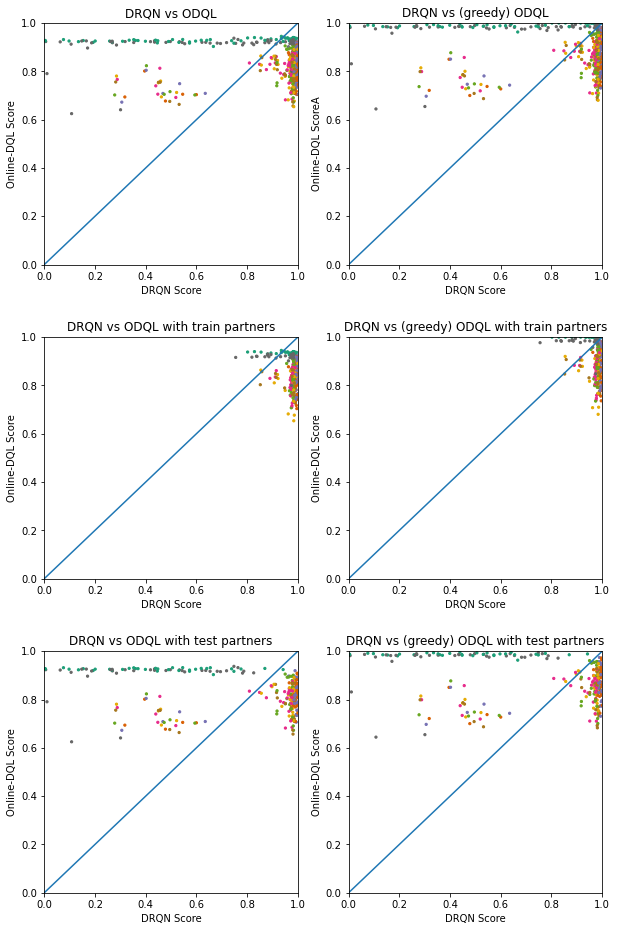

In [110]:
figure, axis = plt.subplots(3, 2, figsize=(10, 16))
figure.subplots_adjust(hspace=.3)

# Entire set
plot_comparison(
    axis[0, 0], 
    drqn_avg_score_by_pattern,
    oql_avg_score_by_pattern,
    'DRQN vs ODQL',
    'DRQN Score',
    'Online-DQL Score',
    c=test_pattern_mask)
plot_comparison(
    axis[0, 1], 
    drqn_avg_score_by_pattern,
    oql_avg_greedy_score_by_pattern,
    'DRQN vs (greedy) ODQL',
    'DRQN Score',
    'Online-DQL ScoreA',
    c=test_pattern_mask)

# Train partners only
drqn_avg_score_by_train_pattern = [score for score_id, score in enumerate(drqn_avg_score_by_pattern) if in_train_mask[score_id]]
oql_avg_score_by_train_pattern = [score for score_id, score in enumerate(oql_avg_score_by_pattern) if in_train_mask[score_id]]
oql_avg_greedy_score_by_train_pattern = [score for score_id, score in enumerate(oql_avg_greedy_score_by_pattern) if in_train_mask[score_id]]
plot_comparison(
    axis[1, 0], 
    drqn_avg_score_by_train_pattern,
    oql_avg_score_by_train_pattern,
    'DRQN vs ODQL with train partners',
    'DRQN Score',
    'Online-DQL Score',
    c=[tp for id, tp in enumerate(test_pattern_mask) if in_train_mask[id]])
plot_comparison(
    axis[1, 1], 
    drqn_avg_score_by_train_pattern,
    oql_avg_greedy_score_by_train_pattern,
    'DRQN vs (greedy) ODQL with train partners',
    'DRQN Score',
    'Online-DQL Score',
    c=[tp for id, tp in enumerate(test_pattern_mask) if in_train_mask[id]])

# Test patterns only
drqn_avg_score_by_test_pattern = [score for score_id, score in enumerate(drqn_avg_score_by_pattern) if not in_train_mask[score_id]]
oql_avg_score_by_test_pattern = [score for score_id, score in enumerate(oql_avg_score_by_pattern) if not in_train_mask[score_id]]
oql_avg_greedy_score_by_test_pattern = [score for score_id, score in enumerate(oql_avg_greedy_score_by_pattern) if not in_train_mask[score_id]]
plot_comparison(
    axis[2, 0], 
    drqn_avg_score_by_test_pattern,
    oql_avg_score_by_test_pattern,
    'DRQN vs ODQL with test partners',
    'DRQN Score',
    'Online-DQL Score',
    c=[tp for id, tp in enumerate(test_pattern_mask) if not in_train_mask[id]])
plot_comparison(
    axis[2, 1], 
    drqn_avg_score_by_test_pattern,
    oql_avg_greedy_score_by_test_pattern,
    'DRQN vs (greedy) ODQL with test partners',
    'DRQN Score',
    'Online-DQL Score',
    c=[tp for id, tp in enumerate(test_pattern_mask) if not in_train_mask[id]])

plt.show()